In [1]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from tqdm.notebook import tqdm, trange

In [7]:
start_date = '2005-01-01'
end_date = '2023-12-12'
if_max = False
actions = True
stock_list = ['GOOG', 'AMZN', 'JPM', 'GME', 'XOM', 'SPY']
period = 40
train_rate = 0.8
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Return']
num_round = 100
params = {'objective': 'regression',
          'metric': 'mse',
          'num_leaves': 31,
          'learning_rate': 0.05,
          'feature_fraction': 0.9}
early_stopping_rounds = 10

In [6]:
# load stock price data
def get_stock_price(stock, if_max=False, start='2022-01-01', end='2023-01-01'):
    if if_max:
        return yf.download(stock, period='max', actions=True)
    else:
        return yf.download(stock, start=start, end=end, actions=True)


def normalization(stock_df):
    for column in stock_df.columns:
        stock_df[column] = (stock_df[column] - stock_df[column].mean()) / stock_df[column].std()
    return stock_df


# check if there is any NA value
def check_na_value(stock_dict):
    for stock in stock_dict.keys():
        if len(stock_dict[stock]) != len(stock_dict[stock].dropna()):
            print(stock, 'null!')
            return False
    print('NULL value Checked!')
    return True


def check_na_value_by_df(stock_df, stock):
    if len(stock_df) != len(stock_df.dropna()):
        print(stock, 'null!')
        return False
    print('NULL value Checked!')
    return True


# get return
def get_return(stock_dict, adj=False):
    label = 'Adj Close' if adj else 'Close'
    for stock in stock_dict.keys():
        stock_dict[stock]['Return'] = stock_dict[stock][label].pct_change().fillna(0)
    return stock_dict


def get_return_by_df(stock_df, adj=False):
    label = 'Adj Close' if adj else 'Close'
    stock_df['Return'] = stock_df[label].pct_change().fillna(0)
    return stock_df


# get corr
def corr_cal(stock_dict, n):
    for stock in stock_dict.keys():
        stock_dict[stock]['Corr_p'] = stock_dict[stock]['Return'].rolling(n).corr(
            stock_dict['SPY']['Return']).shift(-n + 1)
        stock_dict[stock] = stock_dict[stock].iloc[:-n + 1, :]
    return stock_dict

In [4]:
stock_dict = {}

# Data Preparation
for stock in stock_list:
    # data load
    df = get_stock_price(stock, if_max=if_max, start=start_date, end=end_date)
    # null value check
    assert check_na_value_by_df(df, stock)
    # return calculate
    stock_dict[stock] = get_return_by_df(df, adj=actions)

stock_dict = corr_cal(stock_dict, period)

[*********************100%%**********************]  1 of 1 completed
NULL value Checked!
[*********************100%%**********************]  1 of 1 completed
NULL value Checked!
[*********************100%%**********************]  1 of 1 completed
NULL value Checked!
[*********************100%%**********************]  1 of 1 completed
NULL value Checked!
[*********************100%%**********************]  1 of 1 completed
NULL value Checked!
[*********************100%%**********************]  1 of 1 completed
NULL value Checked!


In [15]:
def solo_data_predict(stock_df, rate, features, esr):
  X_train, X_test, y_train, y_test = train_test_split(stock_df[features], stock_df['Corr_p'], test_size=1-rate, random_state=42)

  train_data = lgb.Dataset(X_train, label=y_train)
  test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

  model = lgb.train(params, train_data, num_round, valid_sets=[train_data, test_data])

  y_pred = model.predict(X_test, num_iteration=model.best_iteration)

  return y_pred, y_test

In [16]:
predicted_correlations = {}
actual_correlations = {}
for stock in stock_list[:-1]:
    predicted_correlations[stock], actual_correlations[stock] = solo_data_predict(stock_dict[stock], train_rate, features, early_stopping_rounds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3783, number of used features: 7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.625666
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3783, number of used features: 7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.563858


In [21]:
predicted_correlations_df = pd.DataFrame(columns=[i + ' Predicted_Correlation' for i in stock_list[:-1]])
actual_correlations_df = pd.DataFrame(columns=[i + ' Actual_Correlation' for i in stock_list[:-1]])
for stock in stock_list[:-1]:
    predicted_correlations_df[stock + ' Predicted_Correlation'] = predicted_correlations[stock]
    actual_correlations_df[stock + ' Actual_Correlation'] = actual_correlations[stock].values

In [22]:
result_df = pd.concat([actual_correlations_df, predicted_correlations_df], axis=1)
result_df

,GOOG Actual_Correlation,AMZN Actual_Correlation,JPM Actual_Correlation,GME Actual_Correlation,XOM Actual_Correlation,GOOG Predicted_Correlation,AMZN Predicted_Correlation,JPM Predicted_Correlation,GME Predicted_Correlation,XOM Predicted_Correlation
0,0.350696,0.503174,0.765971,0.234732,0.719560,0.410031,0.474876,0.731290,0.313931,0.637292
1,0.766777,0.701655,0.785798,0.660197,0.672987,0.785281,0.694563,0.780111,0.554456,0.585362
2,0.743257,0.448862,0.640816,0.210994,0.653368,0.756998,0.644918,0.521895,0.214049,0.489330
3,0.490805,0.631620,0.395295,0.153777,0.146626,0.730011,0.615275,0.547008,0.546934,0.194830
4,0.727478,0.548553,0.521924,0.306599,0.527696,0.782018,0.576674,0.565552,0.243087,0.414478
...,...,...,...,...,...,...,...,...,...,...
941,0.598892,0.721729,0.714869,0.035345,0.642374,0.729423,0.729076,0.716171,0.082372,0.629672
942,0.485451,0.762405,0.702972,0.732414,0.823043,0.571019,0.535521,0.759455,0.466644,0.688285
943,0.215713,0.465185,0.843815,0.551674,0.799734,0.535223,0.474359,0.814568,0.500471,0.807996
944,0.716133,0.614069,0.453927,0.282551,0.158553,0.575575,0.526972,0.655215,0.296679,0.373954


<Axes: >

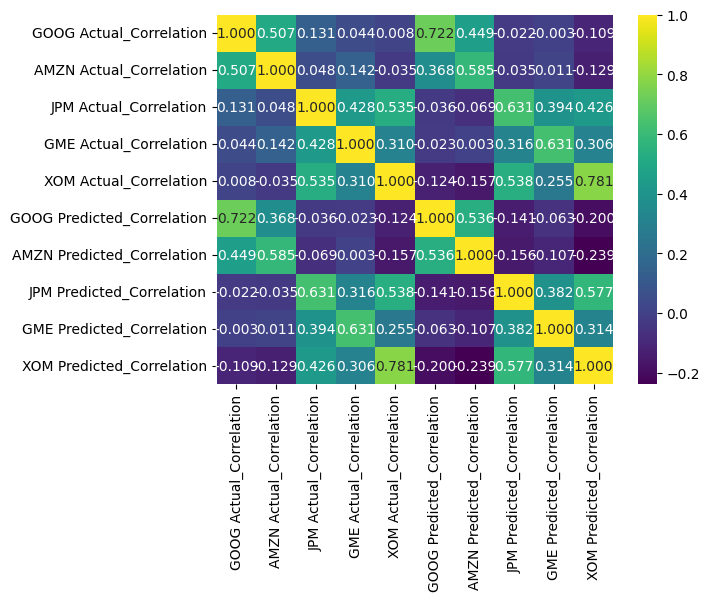

In [23]:
sns.heatmap(result_df.corr(), cmap='viridis', annot=True, fmt=".3f")

In [25]:
for stock in stock_list[:-1]:
  print(f"【{stock}】Mean Squared Error (MSE):", ((result_df[stock + ' Predicted_Correlation'] - result_df[stock + ' Actual_Correlation']) ** 2).mean())

【GOOG】Mean Squared Error (MSE): 0.01940743596578209
【AMZN】Mean Squared Error (MSE): 0.02430824856626552
【JPM】Mean Squared Error (MSE): 0.012258691865699263
【GME】Mean Squared Error (MSE): 0.02443172548733231
【XOM】Mean Squared Error (MSE): 0.017217325689977674
